In [1]:
model_paths = '../output/ablation-mnist-models/*/*.pkl'
relu_path = '../output/ablation-mnist-models/attempt0/relu.pkl'
all_modifications_path = '../output/ablation-mnist-models/attempt0/relog-elliptical-maxout_4-bce-max_fit_l1-overlay.pkl'

# Preparation

In [2]:
import sys
sys.path.append('..')

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import torchvision
import numpy as np
from torch.nn.functional import softmax
import os
from glob import glob
from tqdm import tqdm
import pandas as pd
from collections import OrderedDict

In [4]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

In [5]:
dataset = torchvision.datasets.MNIST(
            root='../mnist',
            train=False,
            transform=torchvision.transforms.ToTensor(), 
        )

In [6]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=False)
x, y = next(iter(loader))

In [7]:
from train import cifar_stats

# levels of noise
k = torch.linspace(0, 1, 101).reshape(-1, 1, 1, 1)

softmax_dim1 = lambda x: softmax(x, dim=1)

def denormalize_cifar_images(batch):
    means, stds = cifar_stats
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return batch * stds + means

cifar_classes = {
    0 : 'airplane',
    1 : 'automobile',
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck',
}

class Plotter(object):

    def __init__(self, idx=None, is_cifar=False):
        self.is_cifar = is_cifar
        idx = idx or np.random.randint(x.shape[0])
        print("Plotting image at index %d" % idx)
        sample1 = x[[idx]]
        if is_cifar:
            sample2 = torch.randn(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k
        else:
            sample2 = torch.rand(*sample1.shape)
            self.xs = sample1 * (1-k) + sample2 * k

    def plot_transition(self):
        if self.xs.shape[1] == 1: # black-and-white
            xs_vals = self.xs[:,0,:,:].numpy()
        elif self.xs.shape[1] == 3: # R-G-B
            if self.is_cifar:
                images = denormalize_cifar_images(self.xs)
            else:
                images = self.xs
            xs_vals = images.permute(0,2,3,1).numpy()
        else:
            raise ValueError('Unsupported image format')
        fig, ax = plt.subplots(1, 5, figsize=(15, 3))
        ax[0].imshow(xs_vals[0])
        ax[0].set_title('Noise level: 0%')
        ax[1].imshow(xs_vals[25])
        ax[1].set_title('Noise level: 25%')
        ax[2].imshow(xs_vals[50])
        ax[2].set_title('Noise level: 50%')
        ax[3].imshow(xs_vals[70])
        ax[3].set_title('Noise level: 75%')
        ax[4].imshow(xs_vals[100])
        ax[4].set_title('Noise level: 100%')
            
    def plot_predictions(self, model, name=None, ax=None):
        name = name or model.name
        model.eval()
        preds, _ = model(self.xs)
        preds = softmax_dim1(preds)
        # because many classes have the same zero prob, we need an additional criteria to
        # choose one that makes the most sense
        mass = preds.sum(axis=0)
        preds_on_true_image, preds_on_noise = preds[0], preds[-1].clone()
        c0, c1 = sorted(range(preds.shape[1]), key=lambda i: (-preds_on_true_image[i], -mass[i]))[:2]
        remaining_indices = [i for i in range(preds.shape[1]) if i not in (c0, c1)]
        c2, c3 = sorted(remaining_indices, key=lambda i: (-preds_on_noise[i], -mass[i]))[:2]
        k_vals = k.flatten().numpy()
        for c in [c0, c1, c2, c3]:
            if self.is_cifar:
                class_name = cifar_classes[c]
            else:
                class_name = str(c)
            (ax or plt).plot(k_vals, preds[:,c].detach().numpy(), label='prediction: %s' %class_name)
        if ax is None: 
            plt.ylim(0, 1)
            plt.title('Model: ' + name)
        else:
            ax.set_ylim(0, 1)
            ax.set_title('Model: ' + name)
        (ax or plt).legend()

In [8]:
def compare_visually(model_a, model_b, idx, is_cifar=False):
    p = Plotter(idx, is_cifar=is_cifar)
    plt.ion()
    p.plot_transition()
    _, axes = plt.subplots(1, 2, figsize=(15,4))
    p.plot_predictions(model_a, ax=axes[0])
    p.plot_predictions(model_b, ax=axes[1])
    plt.ioff()

# Compare two models visually

In [9]:
model_a = load_model(relu_path)
model_b = load_model(all_modifications_path)
model_a.name = 'Baseline'
model_b.name = 'Proposed'

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.ReLog' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'models.Elliptical' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Plotting image at index 84


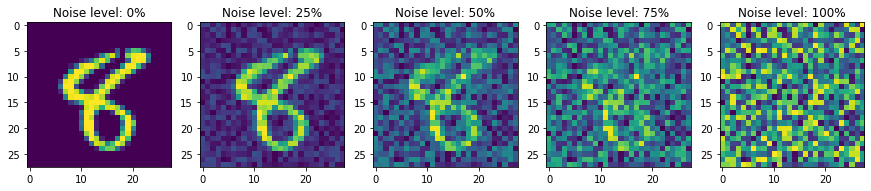

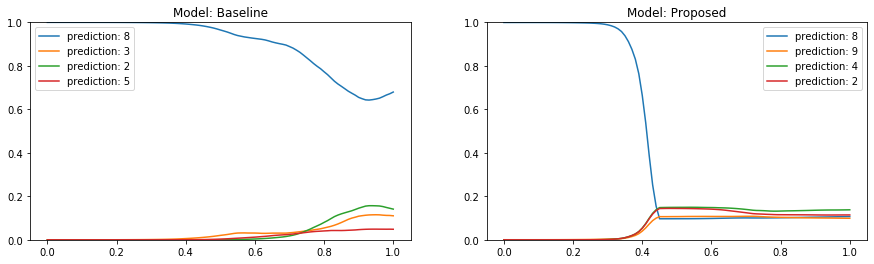

In [10]:
compare_visually(model_a, model_b, 84)

Plotting image at index 41


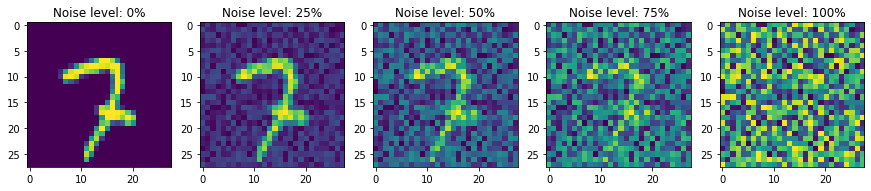

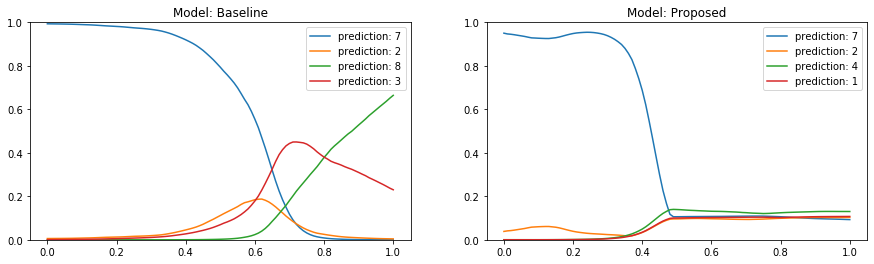

In [11]:
compare_visually(model_a, model_b, 41)

Plotting image at index 8


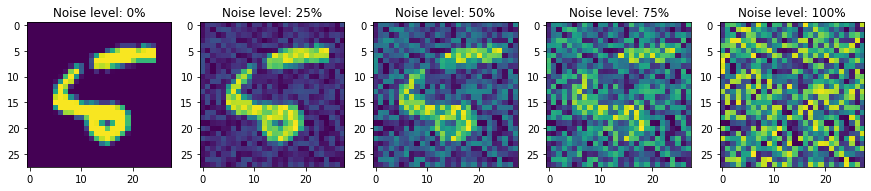

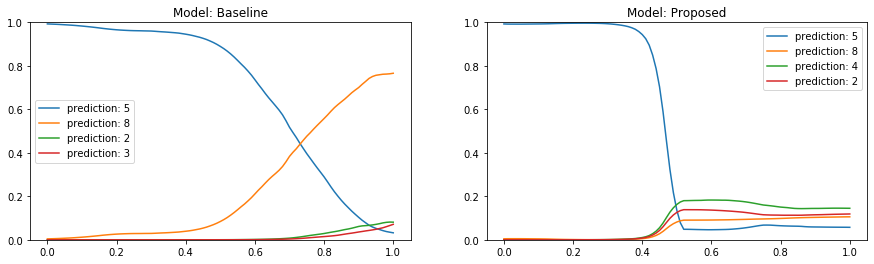

In [12]:
compare_visually(model_a, model_b, 8)

Plotting image at index 908


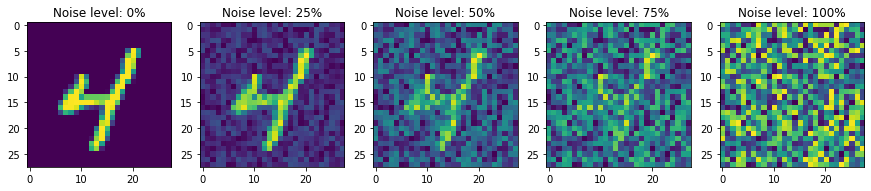

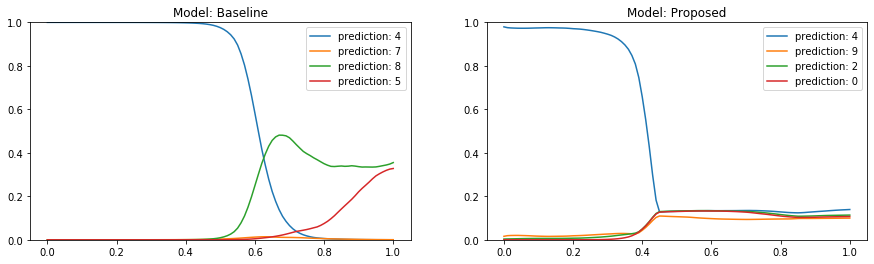

In [13]:
compare_visually(model_a, model_b, 908)

# Evaluate models

In [21]:
def evaluate(model):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)
    x, y = next(iter(loader))
    noise_images = torch.rand(*x.shape)
    
    preds_on_real, _ = model(x)
    max_probs_on_real, predicted_classes = softmax(preds_on_real, dim=1).max(dim=1)
    accuracy_on_real = (predicted_classes == y).float().mean()
    
    preds_on_noise, _ = model(noise_images)
    max_probs_on_noise, _ = softmax(preds_on_noise, dim=1).max(dim=1)
    accuracy_on_noise = (max_probs_on_noise < 0.5).float().mean()
    
    return {
        'acc_on_real': accuracy_on_real.item(),
        'prob_on_real': max_probs_on_real.mean().item(),
        'acc_on_noise': accuracy_on_noise.item(),
        'prob_on_noise': max_probs_on_noise.mean().item(),
    }

# evaluate(load_model('../output/ablation-mnist-models/attempt1/relu-bce-overlay.pkl'))

In [22]:
results = []
with tqdm(glob(model_paths)) as progress:
    for model_path in progress:
        model = load_model(model_path)
        row = evaluate(model)
        row['path'] = model_path
        results.append(row)

100%|██████████| 94/94 [06:02<00:00,  3.85s/it]


In [23]:
results = pd.DataFrame(results)

In [24]:
results['attempt'] = results.path.str.extract(r'/attempt(\d+)/')
results['model'] = results.path.str.extract(r'/([^/]+).pkl$')

In [25]:
results.sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
39,0.991,0.991756,0.000,0.996738,../output/ablation-mnist-models/attempt8/relog...,8,relog-elliptical-maxout_4-bce-max_fit_l1
87,0.992,0.985423,0.039,0.890323,../output/ablation-mnist-models/attempt9/relog...,9,relog-elliptical-maxout_4-max_fit_l1
61,0.990,0.988521,0.132,0.722521,../output/ablation-mnist-models/attempt1/relog...,1,relog-minmaxout_2_4


In [26]:
results[results.model.str.contains('elliptical')].sample(3)

,acc_on_real,prob_on_real,acc_on_noise,prob_on_noise,path,attempt,model
60,0.940,0.848709,0.000,0.979452,../output/ablation-mnist-models/attempt1/relog...,1,relog-elliptical-maxout_4
30,0.981,0.979820,0.000,0.995010,../output/ablation-mnist-models/attempt3/relog...,3,relog-elliptical-maxout_4-bce-max_fit_l1
78,0.989,0.984620,0.002,0.976846,../output/ablation-mnist-models/attempt7/relog...,7,relog-elliptical-maxout_4-max_fit_l1


In [27]:
results.model.unique()

array(['relog', 'relog-maxout_4', 'relog-elliptical-maxout_4-max_fit_l1',
       'relog-elliptical-maxout_4-bce-max_fit_l1', 'relu',
       'relog-elliptical-maxout_4-bce-max_fit_l1-overlay',
       'relog-elliptical-maxout_4', 'relog-minmaxout_2_4',
       'relog-elliptical-bce-max_fit_l1-overlay', 'relu-bce',
       'relu-bce-overlay'], dtype=object)

In [28]:
formatted_names = OrderedDict([
    ('relu', 'Baseline'),
    ('relog-elliptical-maxout_4-max_fit_l1', 'Innate'),  
    ('relu-bce-overlay.pkl', 'Learned'),
    ('relog-elliptical-maxout_4-bce-max_fit_l1-overlay', 'Both'),  
])
model_order = {n: i for i, n in enumerate(formatted_names)}

In [29]:
full_summary = results.drop(columns=['attempt', 'path']).groupby('model').agg(['mean', 'std']).reset_index()
full_summary

model acc_on_real            \
                                                            mean       std   
0                                              relog      0.9899  0.003725   
1            relog-elliptical-bce-max_fit_l1-overlay      0.9479  0.051768   
2                          relog-elliptical-maxout_4      0.9507  0.010894   
3           relog-elliptical-maxout_4-bce-max_fit_l1      0.9729  0.012032   
4   relog-elliptical-maxout_4-bce-max_fit_l1-overlay      0.9551  0.026723   
5               relog-elliptical-maxout_4-max_fit_l1      0.9902  0.003225   
6                                     relog-maxout_4      0.9920  0.002494   
7                                relog-minmaxout_2_4      0.9928  0.002616   
8                                               relu      0.9921  0.002998   
9                                           relu-bce      0.9930  0.004243   
10                                  relu-bce-overlay      0.9965  0.000707   

   prob_on_real           acc_on_noise           prob_on_noise            
           mean       std         mean       std          mean       std  
0      0.987671  0.002806       0.0357  0.021443      0.821444  0.051554  
1      0.923568  0.099850       0.1694  0.235510      0.755114  0.179994  
2      0.854988  0.019450       0.0032  0.004826      0.958627  0.035653  
3      0.966427  0.017586       0.0000  0.000000      0.996793  0.002913  
4      0.953783  0.023189       0.9216  0.247221      0.212144  0.156376  
5      0.984067  0.002673       0.0262  0.039969      0.909021  0.076830  
6      0.988993  0.002465       0.0264  0.038896      0.875297  0.089203  
7      0.986563  0.003646       0.0373  0.041868      0.838581  0.090930  
8      0.990362  0.001084       0.2298  0.148853      0.638192  0.075813  
9      0.994786  0.000490       0.0850  0.021213      0.712498  0.028033  
10     0.996054  0.000146       0.1050  0.121622      0.769507  0.134377

In [30]:
summary = full_summary[full_summary.model.isin(formatted_names)]
summary['model_order'] = summary.model.apply(model_order.__getitem__)
summary = summary.sort_values(['model_order']).drop(columns='model_order')
summary['model'] = summary.model.apply(formatted_names.__getitem__)
summary = summary.reset_index(drop=True)
summary

/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/cumeo/anaconda3/envs/newlogic/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


model acc_on_real           prob_on_real           acc_on_noise  \
                   mean       std         mean       std         mean   
0  Baseline      0.9921  0.002998     0.990362  0.001084       0.2298   
1    Innate      0.9902  0.003225     0.984067  0.002673       0.0262   
2      Both      0.9551  0.026723     0.953783  0.023189       0.9216   

            prob_on_noise            
        std          mean       std  
0  0.148853      0.638192  0.075813  
1  0.039969      0.909021  0.076830  
2  0.247221      0.212144  0.156376

In [31]:
formatted = summary.round(2)
formatted['acc_on_noise_str'] = formatted[('acc_on_noise', 'mean')].astype(str) + ' pm ' + formatted[('acc_on_noise', 'std')].astype(str)
formatted = formatted.drop(columns=[('prob_on_real', 'std'), 'acc_on_real', 
                                  ('prob_on_noise', 'std'), 'acc_on_noise'])
print(formatted.to_latex())

\begin{tabular}{llrrl}
\toprule
{} &     model & prob\_on\_real & prob\_on\_noise & acc\_on\_noise\_str \\
{} &         mean & \multicolumn{2}{l}{mean} \\
\midrule
0 &  Baseline &         0.99 &          0.64 &     0.23 pm 0.15 \\
1 &    Innate &         0.98 &          0.91 &     0.03 pm 0.04 \\
2 &      Both &         0.95 &          0.21 &     0.92 pm 0.25 \\
\bottomrule
\end{tabular}



### Previous result (2019)

```
for path in paths:
    print('%s: %.2f (std=%.2f)' %(os.path.basename(path), *measure_accuracy_on_noise(load_model(path))))
    
relu.pkl: 0.28 (std=0.05)
relog.pkl: 0.06 (std=0.03)
relu-maxout.pkl: 0.05 (std=0.02)
relu-minmaxout.pkl: 0.02 (std=0.01)
relu-elliptical.pkl: 0.01 (std=0.01)
relu-max_fit_l1.pkl: 0.48 (std=0.05)
relu-mse.pkl: 0.08 (std=0.03)
relu-mse-overlay.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-max_fit_l1.pkl: 0.00 (std=0.00)
relog-elliptical-maxout_4-max_fit_l1.pkl: 1.00 (std=0.00)
relu-elliptical-max_fit-maxout.pkl: 0.79 (std=0.04)
relu-elliptical-maxout.pkl: 0.03 (std=0.02)
```

In [ ]:
# check if the architecture is correct
load_model(relu_elliptical_maxout_path)

## Examining some models

In [ ]:
relu_elliptical_maxfit_maxout = load_model(relu_elliptical_maxfit_maxout_path)
relu_elliptical_maxfit_maxout.name = 'Elliptical + MaxFit + MaxOut'

In [ ]:
p = Plotter(223)
p.plot_predictions(relu_elliptical_maxfit_maxout)

In [ ]:
p = Plotter(5898)
p.plot_predictions(relu_elliptical_maxfit_maxout)

In [ ]:
p = Plotter(6753)
p.plot_predictions(relu_elliptical_maxfit_maxout)

In [ ]:
p = Plotter(4148)
p.plot_predictions(relu_elliptical_maxfit_maxout)

# CIFAR-10 models

In [ ]:
cifar10_baseline_path = '../output/ablation-cifar10-models/relu.pkl'
cifar10_modified_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit.pkl'
cifar10_modified_with_bce_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce.pkl'
cifar10_modified_with_overlay_path = '../output/ablation-cifar10-models4/relog-minmaxout-elliptical_stop1-maxfit-bce-overlay.pkl'

In [ ]:
cifar10_model_a = load_model(cifar10_baseline_path)
cifar10_model_b = load_model(cifar10_modified_path)
cifar10_model_c = load_model(cifar10_modified_with_bce_path)
cifar10_model_d = load_model(cifar10_modified_with_overlay_path)

In [ ]:
cifar10_model_a.name = 'Baseline'
cifar10_model_b.name = 'Proposed (no BCE)'
cifar10_model_d.name = 'Proposed (BCE+Overlay)'

In [ ]:
transform_test = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*cifar_stats)
])
cifar10_testset = torchvision.datasets.CIFAR10(root='../cifar10', train=False, download=False, transform=transform_test)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
x, y = next(iter(cifar10_testloader))

In [ ]:
p = Plotter(3, is_cifar=True)

In [ ]:
p.plot_transition()

In [ ]:
p.plot_predictions(cifar10_model_a)

In [ ]:
p.plot_predictions(cifar10_model_b)

In [ ]:
p.plot_predictions(cifar10_model_d)

In [ ]:
p = Plotter(138, is_cifar=True)

In [ ]:
p.plot_transition()

In [ ]:
p.plot_predictions(cifar10_model_a)

In [ ]:
p.plot_predictions(cifar10_model_b)

In [ ]:
p.plot_predictions(cifar10_model_d)

In [ ]:
p = Plotter(118, is_cifar=True)

In [ ]:
p.plot_transition()

In [ ]:
p.plot_predictions(cifar10_model_a)

In [ ]:
p.plot_predictions(cifar10_model_b)

In [ ]:
p.plot_predictions(cifar10_model_d)

In [ ]:
p = Plotter(197, is_cifar=True)

In [ ]:
p.plot_transition()

In [ ]:
p.plot_predictions(cifar10_model_a)

In [ ]:
p.plot_predictions(cifar10_model_b)

In [ ]:
p.plot_predictions(cifar10_model_d)

## Measure accuracy on noise

In [ ]:
noise_images = torch.randn(1000, 3, 32, 32) # used in measure_accuracy_on_noise()

In [ ]:
measure_accuracy_on_noise(cifar10_model_a)

In [ ]:
measure_accuracy_on_noise(cifar10_model_b)

In [ ]:
measure_accuracy_on_noise(cifar10_model_c)

In [ ]:
measure_accuracy_on_noise(cifar10_model_d)

## Measure max propbability

In [ ]:
from scipy import stats

def compare_max_probs_on_noise(model1, model2):
    preds1, _ = model1(noise_images)
    max_probs1, _ = softmax(preds1, dim=1).max(dim=1)
    print('Model1: mean=%f, std=%f' %(max_probs1.mean().item(), max_probs1.std().item()))
    
    preds2, _ = model2(noise_images)
    max_probs2, _ = softmax(preds2, dim=1).max(dim=1)
    print('Model2: mean=%f, std=%f' %(max_probs2.mean().item(), max_probs2.std().item()))

    _, p_value = stats.ttest_ind(max_probs1.detach().numpy(), max_probs2.detach().numpy())
    print('p-value:', p_value)
    return max_probs1.mean(), max_probs2.mean()

In [ ]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_b)

In [ ]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_c)

In [ ]:
compare_max_probs_on_noise(cifar10_model_a, cifar10_model_d)

## Check the overlay model

The BCE+Overlay model seems to perform well on noise but actually it always give low probability everywhere and only predict accurately in 43% cases. Let's see if there's any difference between actual images and noise...?

In [ ]:
preds, _ = cifar10_model_d(x)
max_probs, _ = softmax(preds, dim=1).max(dim=1)
(max_probs.mean().item(), max_probs.std().item())